 # TF Agent で Blackjack 遊ぶ

 ブラックジャックを参考に、次のような
 ルールとする。
 
 ## ルール

 - カードの値は、 1〜10の間にランダムに決まる（エースは1か11）
 - 最初にカードをプレイヤーに2枚、ディーラーに1枚
 - プレイヤーが何枚でもカードを引ける(hit)が、合計が21超えたら即負け。ゲーム終了
 - プレイヤーがカードを引くのを止めたら(stick)、ディーラーがカードを引く番になる
 - ディーラーは、カードの合計が17に達するまでカードを強制的に引く
 - ディーラーのカードの合計が21超えたら、プレイヤーの勝ち。ゲーム終了
 - ディーラーとプレイヤーとでカードの合計を比較して、プレイヤーが高いなら勝ち。引き分けはなし。ゲーム終了
 - プレイヤーが勝つ場合 1 点。負け（引き分けも）は 0 点
 
## 参考

- [TF Agents DQN example](https://github.com/tensorflow/agents/blob/154b81176041071a84b72eb64d419d256dcc947a/tf_agents/agents/dqn/examples/v2/train_eval.py)
- [Kaggle BlackJack env](https://github.com/Kaggle/learntools/blob/master/learntools/python/blackjack.py)
- [How to match DeepMind’s Deep Q-Learning score in Breakout](https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756)

In [1]:
# !which python
# !sudo apt install -y cuda-cublas-10-0  cuda-cusolver-10-0 cuda-cudart-10-0 cuda-cusparse-10-0
# !conda install -y -c anaconda cudatoolkit
!pip install --upgrade tf-nightly-gpu tf-agents-nightly gym
# !pip install --upgrade tensorflow-gpu==2.0.0-alpha0 tf-agents-nightly gym
# !pip install --upgrade tf-nightly-gpu tf-agents-nightly gym


Requirement already up-to-date: tf-nightly-gpu in /conda/envs/alpha0gen/lib/python3.6/site-packages (1.14.1.dev20190410)
Requirement already up-to-date: tf-agents-nightly in /conda/envs/alpha0gen/lib/python3.6/site-packages (0.2.0.dev20190321)
Requirement already up-to-date: gym in /conda/envs/alpha0gen/lib/python3.6/site-packages (0.12.1)


In [2]:
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
from tf_agents.drivers import dynamic_step_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.agents.dqn import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.environments import utils
import numpy as np
import tensorflow as tf
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import suite_gym
from tf_agents.environments import time_step
from tf_agents.specs import array_spec

tf.compat.v1.enable_v2_behavior()
assert tf.executing_eagerly()
# tf.enable_eager_execution()

In [3]:
DEBUG = 1 # @param
WIN_SCORE = 1 # @param
LOSS_SCORE = DRAW_SCORE = 0 # @param

In [4]:
def plog(msg, *args):
    if not DEBUG: return
    if len(args) == 0:
        print(msg)
    else:
        print(msg.format(*args))
DEBUG = 1
plog("abc")
plog("abc {}", 1)
DEBUG = 0

abc
abc 1


## ブラックジャック環境定義

In [5]:
class CardSet:
    LIMIT_SCORE = 21
    DEALER_MIN = 17
    ACE_VAL = 1
    def __init__(self, is_dealer=False):
        self.cards = []
        if is_dealer:
            self.dealer_hit()
        else:
            self.hit(), self.hit()
        
    def add(self, card):
        self.cards.append(card)
        
    def sum(self):
        sum = np.sum(self.cards)
        
        for i in range(1, self.aces()+1):
            if (sum + 10) <= self.LIMIT_SCORE:
                sum += 10
            else:
                break
        return sum
    
    def aces(self):
        n_aces = len(self.cards) - np.count_nonzero(np.array(self.cards)-
                                                   self.ACE_VAL)
        # print(f'n_aces {n_aces}')
        return n_aces

    def is_bust(self):
        return self.sum() > self.LIMIT_SCORE
    
    def __getitem__(self, key):
        return self.cards[key]

    def hit(self):
        # Simplified Blackjack rule
        new_card = np.random.randint(1, 10+1)
        self.add(new_card)

    def dealer_hit(self):
        while self.sum() < self.DEALER_MIN:
            self.hit()
        return self.sum()

    def _player_score(self):
        return np.sum(self._player_cards)

    def __str__(self):
        return str(self.cards)
    
    
class BlackJackEnv(py_environment.PyEnvironment):
    # Simplified Blackjack
    ACT_HIT = 0
    ACT_STICK = 1
    STATE_LEN = 3

    def __init__(self):
        self._batch_size = 1  # batch_size
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, name='action',
            minimum=self.ACT_HIT, maximum=self.ACT_STICK,
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self.STATE_LEN,), dtype=np.int32, minimum=0,
            name='observation'
        )
        self.reset()
        return

    def _state(self):
        state = [self._dealer_cards[0], 
                 self._player_cards.sum(), self._player_cards.aces()]
        assert len(state) == self.STATE_LEN
        return np.array(state, dtype=np.int32)

    def _state_last_cards(self):
        # Full state includes 1st card of the dealer and all cards of player,
        # but this return only the last _state_len cards.
        state = [self._dealer_cards[0]] + self._player_cards.cards
        if len(state) < self._state_len:
            state = np.pad(state, (0, self._state_len-len(state)),
                           'constant', constant_values=(0))
        return np.array(state[-self._state_len:], dtype=np.int32)

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def __reset(self):
        self._player_cards = CardSet(is_dealer=False)
        self._dealer_cards = CardSet(is_dealer=True)
        self._episode_ended = False

    def _reset(self):
        self.__reset()
        return time_step.restart(self._state())
        
    def _terminate(self, reward):
        plog(
            "Player: {} -> {}. Dealer: {} -> {}. Reward: {}.",
            self._player_cards, self._player_cards.sum(),
            self._dealer_cards, self._dealer_cards.sum(),
            reward)
        self._episode_ended = True
        return time_step.termination(self._state(), reward)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()  # don't forget to `return`

        if action == self.ACT_HIT:
            self._player_cards.hit()
            if self._player_cards.is_bust():
                return self._terminate(LOSS_SCORE)

            return time_step.transition(self._state(), reward=0, discount=1)

        # Afteward action == self.ACT_STICK
        dealer_score = self._dealer_cards.dealer_hit()
        player_score = self._player_cards.sum()
        if self._dealer_cards.is_bust() or dealer_score < player_score:
            reward = WIN_SCORE
        else:
            reward = LOSS_SCORE
        return self._terminate(reward)


    @classmethod
    def tf_env(cls):
        return tf_py_environment.TFPyEnvironment(cls())


def print_spec(env):
    act_spec, ts_spec = env.action_spec(), env.time_step_spec()
    for x in (act_spec, ts_spec.observation, ts_spec.step_type,
              ts_spec.discount, ts_spec.reward):
        print(x)
    return


# TODO: validate_py_environment should check for a reset()
utils.validate_py_environment(BlackJackEnv())


## 既知の戦略で勝率<38%

- [Kaggle BlackJack env](https://github.com/Kaggle/learntools/blob/master/learntools/python/blackjack.py)
- [Kaggle BlackJack microchallange forum](https://www.kaggle.com/learn-forum/58735#latest-348767)

W0412 15:01:47.612896 140363654547264 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0412 15:01:47.615910 140363654547264 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0412 15:01:47.621510 140363654547264 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0412 15:01:47.625596 140363654547264 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0412 15:01:47.629155 140363654547264 backprop.py:820] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32


Step 1000. Gain 0.3790000081062317.
Step 2000. Gain 0.37299999594688416.
Step 3000. Gain 0.3720000088214874.
Step 4000. Gain 0.3737500011920929.
Step 5000. Gain 0.376800000667572.
Step 6000. Gain 0.37400001287460327.
Step 7000. Gain 0.3734285831451416.
Step 8000. Gain 0.3736250102519989.
Step 9000. Gain 0.370888888835907.
Step 10000. Gain 0.3693999946117401.


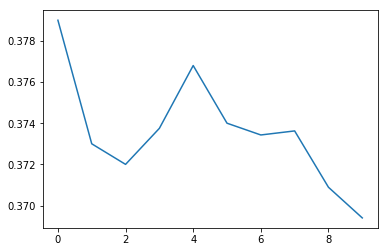

In [6]:
def should_hit(dealer_card_val, player_total, player_aces):
    """既知の戦略
    Return True if the player should hit (request another card) given the current game
    state, or False if the player should stay. player_aces is the number of aces the player has.
    Strategy learnt from https://www.kaggle.com/learn-forum/58735#latest-348767
    """
    hit = (
        (player_total <= 11) or
        (player_total == 12 and (dealer_card_val < 4 or dealer_card_val > 6)) or
        (player_total <= 16 and (dealer_card_val > 6)) or
        (player_total == 17 and (dealer_card_val == 1))
    )
#     print(f"Dealer {dealer_card_val}. Player {player_total}, aces {player_aces}, hit {hit}")
    return hit

def play_known_strategy(env):
    ts = env.reset()
    gain = ts.reward    
    dealer_card_val, player_total, player_aces = ts.observation.numpy()[0]
    while should_hit(dealer_card_val, player_total, player_aces):        
        ts = env.step(tf.constant([BlackJackEnv.ACT_HIT]))
        gain += ts.reward
        dealer_card_val, player_total, player_aces = ts.observation.numpy()[0]
    if not ts.is_last():
        ts = env.step(tf.constant([BlackJackEnv.ACT_STICK]))
        gain += ts.reward
    gain = gain.numpy()[0]
    return gain

DEBUG = 0  # @param
log_interval = 1000  # @param
num_iterations = 10_000  # @param

env = BlackJackEnv.tf_env()
gains = []
avg_gains =[]
for step in range(1, 1+num_iterations):
    gain = play_known_strategy(env)
    gains.append(gain)
    if step % log_interval == 0:     
        avg_gain = np.mean(gains)
        avg_gains.append(avg_gain)
        print(f'Step {step: >3}. Gain {avg_gain}.')
plt.plot(avg_gains)

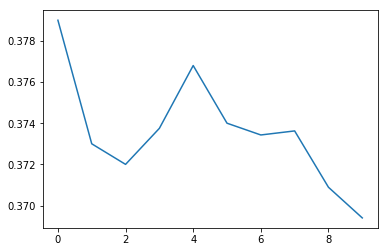

In [7]:
plt.plot(avg_gains)

 ## デタラメに遊ぶ場合

 プレイヤーがカードを最大 `n_max_cards` 枚引く。
 平均的に見たら負けています。


### 最大１枚引く場合、勝率<30.6%

In [8]:
def play_blackjack(env, n_max_cards=1):
    ts = env.reset()
    gain = ts.reward
    cards = []
    for _ in range(np.random.randint(n_max_cards+1)):
        if ts.is_last():
            break
        ts = env.step(tf.constant([BlackJackEnv.ACT_HIT]))
        assert ts.reward >= LOSS_SCORE
        gain += ts.reward

    if not ts.is_last():
        ts = env.step(tf.constant([BlackJackEnv.ACT_STICK]))
        gain += ts.reward
    gain = gain.numpy()[0]
    return gain



In [9]:
DEBUG = 0  # @param
num_iterations = 5_000  # @param
log_interval = 1_000  # @param
n_max_cards = 1  # @param

env = BlackJackEnv.tf_env()
gains = []
for step in range(1, 1+num_iterations):
    gain = play_blackjack(env, n_max_cards)
    gains.append(gain)
    if step % log_interval == 0:        
        print(f'Step {step: >3}. Gain {np.mean(gains)}.')

Step 1000. Gain 0.3050000071525574.
Step 2000. Gain 0.29899999499320984.
Step 3000. Gain 0.3016666769981384.
Step 4000. Gain 0.30399999022483826.
Step 5000. Gain 0.30219998955726624.


### 最大2枚引く場合、勝率<28.7%

In [10]:
num_iterations = 5_000  # @param
log_interval = 1_000  # @param
n_max_cards = 2  # @param

env = BlackJackEnv.tf_env()
gains = []
for step in range(1, 1+num_iterations):
    gain = play_blackjack(env, n_max_cards)
    gains.append(gain)
    if step % log_interval == 0:        
        print(f'Step {step: >3}. Gain {np.mean(gains)}.')

Step 1000. Gain 0.2720000147819519.
Step 2000. Gain 0.27399998903274536.
Step 3000. Gain 0.2750000059604645.
Step 4000. Gain 0.27549999952316284.
Step 5000. Gain 0.27219998836517334.


 ### RandomTFPolicyで勝率<28.3%

`tf_metrics.AverageReturnMetric(buffer_size)` を使う時には buffer_size に勝率を図るエピソード数を代入。

Evaluated n_episodes   1. avg_return 0.000000. n_win 0
Evaluated n_episodes   2. avg_return 0.000000. n_win 0
Evaluated n_episodes   3. avg_return 0.000000. n_win 0
Evaluated n_episodes   4. avg_return 0.000000. n_win 0
Evaluated n_episodes   5. avg_return 0.000000. n_win 0
Evaluated n_episodes   6. avg_return 0.000000. n_win 0
Evaluated n_episodes   7. avg_return 0.000000. n_win 0
Evaluated n_episodes   8. avg_return 0.000000. n_win 0
Evaluated n_episodes   9. avg_return 0.000000. n_win 0
Evaluated n_episodes  10. avg_return 0.000000. n_win 0
Evaluated n_episodes  11. avg_return 0.000000. n_win 0
Evaluated n_episodes  12. avg_return 1.000000. n_win 12
Evaluated n_episodes  13. avg_return 0.000000. n_win 0
Evaluated n_episodes  14. avg_return 0.000000. n_win 0
Evaluated n_episodes  15. avg_return 0.000000. n_win 0
Evaluated n_episodes  16. avg_return 0.000000. n_win 0
Evaluated n_episodes  17. avg_return 0.000000. n_win 0
Evaluated n_episodes  18. avg_return 1.000000. n_win 18
Evaluate

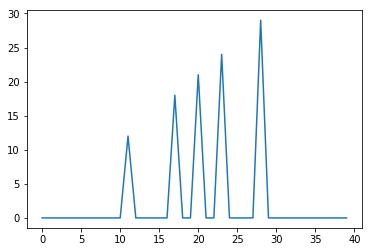

In [11]:
class PolicyEvaluator:
    def __init__(self,        
        eval_env, 
        n_eval_episodes
    ):
        self.eval_env = eval_env
        avg_return = tf_metrics.AverageReturnMetric(buffer_size=n_eval_episodes)
        n_episodes = tf_metrics.NumberOfEpisodes()
        self.observers = [avg_return, n_episodes, ]
        self.n_eval_episodes = n_eval_episodes
        
    def evaluate_policy(self, policy):
        driver = dynamic_episode_driver.DynamicEpisodeDriver(
            self.eval_env, policy, self.observers, self.n_eval_episodes)
        driver.run()
        avg_return, n_episodes = self.observers
        avg_return = avg_return.result().numpy()
        n_episodes = n_episodes.result().numpy()
        n_win = int(n_episodes * avg_return)
        print(f'Evaluated n_episodes {n_episodes: >3}. avg_return {avg_return:f}. n_win {n_win}')
        return avg_return

def repeat_evaluate_random_policy(n_iterations, n_episodes):
    env = BlackJackEnv.tf_env()
    policy = random_tf_policy.RandomTFPolicy(
        action_spec=env.action_spec(),
        time_step_spec=env.time_step_spec(),)
    evaluator = PolicyEvaluator(env, n_episodes)
    gains = []
    for step in range(1, 1+n_iterations//n_episodes):
        avg_return = evaluator.evaluate_policy(policy)
        gains.append(avg_return)
    return gains

DEBUG = False
gains = repeat_evaluate_random_policy(40, 1)
plt.plot(np.multiply(gains, range(1, 41, 1)))

Evaluated n_episodes  10. avg_return 0.400000. n_win 4
Evaluated n_episodes  20. avg_return 0.300000. n_win 6
Evaluated n_episodes  30. avg_return 0.200000. n_win 6
Evaluated n_episodes  40. avg_return 0.300000. n_win 12
Evaluated n_episodes  50. avg_return 0.400000. n_win 20
Evaluated n_episodes  60. avg_return 0.300000. n_win 18
Evaluated n_episodes  70. avg_return 0.300000. n_win 21
Evaluated n_episodes  80. avg_return 0.200000. n_win 16
Evaluated n_episodes  90. avg_return 0.200000. n_win 18
Evaluated n_episodes 100. avg_return 0.000000. n_win 0
Evaluated n_episodes 110. avg_return 0.200000. n_win 22
Evaluated n_episodes 120. avg_return 0.100000. n_win 12
Evaluated n_episodes 130. avg_return 0.200000. n_win 26
Evaluated n_episodes 140. avg_return 0.400000. n_win 56
Evaluated n_episodes 150. avg_return 0.200000. n_win 30
Evaluated n_episodes 160. avg_return 0.200000. n_win 32
Evaluated n_episodes 170. avg_return 0.000000. n_win 0
Evaluated n_episodes 180. avg_return 0.300000. n_win 

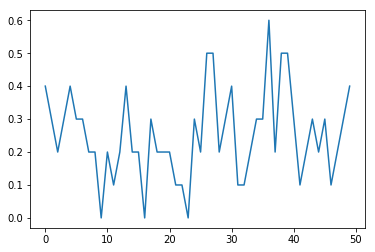

In [12]:
gains

DEBUG = False
gains = repeat_evaluate_random_policy(500, 10)
plt.plot(gains)

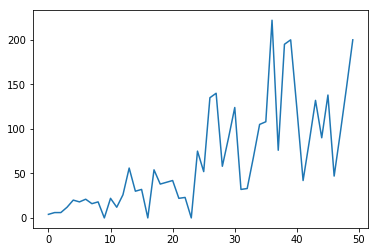

In [ ]:
plt.plot(np.multiply(gains, range(10, 510, 10)))

Evaluated n_episodes 1000. avg_return 0.257000. n_win 256
Evaluated n_episodes 2000. avg_return 0.241000. n_win 481
Evaluated n_episodes 3000. avg_return 0.251000. n_win 752
Evaluated n_episodes 4000. avg_return 0.243000. n_win 972
Evaluated n_episodes 5000. avg_return 0.257000. n_win 1284
Evaluated n_episodes 6000. avg_return 0.229000. n_win 1374
Evaluated n_episodes 7000. avg_return 0.257000. n_win 1798
Evaluated n_episodes 8000. avg_return 0.237000. n_win 1896
Evaluated n_episodes 9000. avg_return 0.271000. n_win 2438
Evaluated n_episodes 10000. avg_return 0.267000. n_win 2669


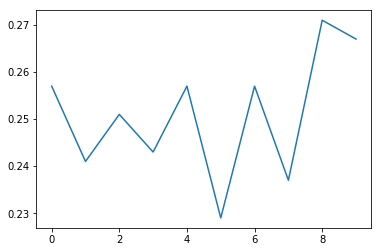

In [ ]:
gains = repeat_evaluate_random_policy(10_000, 1000)
plt.plot(gains)

 ## DQN強化学習
 
Agentに見せる環境の情報 (state) のパターン
- ディーラーの最初のカード
- プレイヤーのカードの合計値
- プレイヤーのエースカードの数


In [ ]:
class DqnAgent:
    def __init__(self, env):
        # Agent初期化
        self.env = env
        q_net = q_network.QNetwork(
            env.observation_spec(),
            env.action_spec(),
            fc_layer_params=fc_layer_params,
        )

        adam = tf.compat.v1.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=0.8, epsilon=1)

        train_step_counter = tf.compat.v2.Variable(0)

        self.agent = dqn_agent.DqnAgent(
            env.time_step_spec(),
            env.action_spec(),
            q_network=q_net,
            optimizer=adam,
            td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
            train_step_counter=train_step_counter,
        )
        self.agent.initialize()
        self._create_replay_buffer()
        eval_env = BlackJackEnv.tf_env()
        self.evaluator = PolicyEvaluator(eval_env, n_eval_episodes)

    # TODO: try different num_steps value
    def _create_replay_buffer(self, num_steps=2):
        # Replay Bufferの初期化。初期データ収集
        self.replay_buffer = buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
            data_spec=self.agent.collect_data_spec,
            batch_size=self.env.batch_size,  # actually 1, env isn't batched
            max_length=replay_buffer_capacity
        )
        print(buffer.capacity.numpy(), buffer._batch_size)
        print(buffer.data_spec)
        self._collect_data(
            self.agent.collect_policy,
            initial_collect_steps)
        dataset = buffer.as_dataset(
            num_parallel_calls=3, num_steps=num_steps,
            sample_batch_size=batch_size,
        ).prefetch(batch_size)
        self.data_iterator = iter(dataset)

    def _collect_data(self, policy, n_steps):
        # Replay Bufferへのデータ追加
        dynamic_step_driver.DynamicStepDriver(
            self.env, policy, [self.replay_buffer.add_batch], n_steps
        ).run()
        return

    def train(self, num_iterations):
        avg_returns = []
        for step in range(1, 1 + num_iterations):
            self._collect_data(self.agent.collect_policy,
                               collect_steps_per_iteration)
            experience, _ = next(self.data_iterator)
            train_loss = self.agent.train(experience)
            self._print_log(step, train_loss.loss, avg_returns)
        return avg_returns

    def _print_log(self, step, loss, avg_returns):
        if step % log_interval == 0:
            print(f'Step {step: >3}. Loss {loss}.')
        if step % eval_interval == 0:
            avg_return = self.evaluator.evaluate_policy(self.agent.policy)
            print(f'Step {step: >3}. AvgReturn {avg_return}.')
            avg_returns.append(avg_return)

def plot(avg_returns, num_iterations, eval_interval):
    steps = range(0, num_iterations + 1, eval_interval)
    plt.ylabel('Average Return')
    plt.xlabel('Step')
    plt.plot(steps, avg_returns)
    # plt.ylim(top=210)



### 勝率36.4%

In [ ]:
DEBUG = False
log_interval = 100  # @param
eval_interval = 500  # @param
num_iterations = 100_000  # @param
learning_rate = 5e-6  # @param
batch_size = 1000  # @param
collect_steps_per_iteration = 8  # @param
initial_collect_steps = batch_size  # @param
n_eval_episodes = 1000  # @param
replay_buffer_capacity = 10_000  # @param
fc_layer_params = (100, )  # @param


dqn = DqnAgent(BlackJackEnv.tf_env())
avg_returns = dqn.train(num_iterations)

plot(avg_returns, num_iterations, eval_interval)


10000 1
Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(3,), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(2147483647, dtype=int32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))
Step 100. Loss 4.184565544128418.
Step 200. Loss 3.57106876373291.
Step 300. Loss 2.931997537612915.
Step 400. Loss 2.5368874073028564.
Step 500. Loss 2.0849721431732178.
Evaluated n_episodes 1000. avg_return 0.000000. n_win 0
Step 500. AvgReturn 0.0.
Step 600. Loss 1.6928638219833374.
Step 700. Loss 1.3656327724456787.
Step 800. Loss 1.2340880

Evaluated n_episodes 27000. avg_return 0.321000. n_win 8667
Step 13500. AvgReturn 0.32100000977516174.
Step 13600. Loss 0.08755737543106079.
Step 13700. Loss 0.07557066529989243.
Step 13800. Loss 0.09035655111074448.
Step 13900. Loss 0.08111684769392014.
Step 14000. Loss 0.08403796702623367.
Evaluated n_episodes 28000. avg_return 0.302000. n_win 8455
Step 14000. AvgReturn 0.3019999861717224.
Step 14100. Loss 0.08627063035964966.
Step 14200. Loss 0.08165566623210907.
Step 14300. Loss 0.09363444149494171.
Step 14400. Loss 0.08038024604320526.
Step 14500. Loss 0.08664851635694504.
Evaluated n_episodes 29000. avg_return 0.314000. n_win 9106
Step 14500. AvgReturn 0.3140000104904175.
Step 14600. Loss 0.08832742273807526.
Step 14700. Loss 0.08919334411621094.
Step 14800. Loss 0.0923624187707901.
Step 14900. Loss 0.08941559493541718.
Step 15000. Loss 0.09098038822412491.
Evaluated n_episodes 30000. avg_return 0.318000. n_win 9539
Step 15000. AvgReturn 0.3179999887943268.
Step 15100. Loss 0.088

Step 27600. Loss 0.09011746197938919.
Step 27700. Loss 0.08643058687448502.
Step 27800. Loss 0.09354650229215622.
Step 27900. Loss 0.09039093554019928.
Step 28000. Loss 0.09664475917816162.
Evaluated n_episodes 56000. avg_return 0.297000. n_win 16631
Step 28000. AvgReturn 0.296999990940094.
Step 28100. Loss 0.08706453442573547.
Step 28200. Loss 0.07442130148410797.
Step 28300. Loss 0.08123400807380676.
Step 28400. Loss 0.09070692211389542.
Step 28500. Loss 0.09142283350229263.
Evaluated n_episodes 57000. avg_return 0.325000. n_win 18524
Step 28500. AvgReturn 0.32499998807907104.
Step 28600. Loss 0.0839870274066925.
Step 28700. Loss 0.08403944224119186.
Step 28800. Loss 0.08320701867341995.
Step 28900. Loss 0.09223927557468414.
Step 29000. Loss 0.08171742409467697.
Evaluated n_episodes 58000. avg_return 0.325000. n_win 18849
Step 29000. AvgReturn 0.32499998807907104.
Step 29100. Loss 0.08462150394916534.
Step 29200. Loss 0.09053517132997513.
Step 29300. Loss 0.08730493485927582.
Step 29

Step 41600. Loss 0.0868711844086647.
Step 41700. Loss 0.08535047620534897.
Step 41800. Loss 0.08583106845617294.
Step 41900. Loss 0.08291298896074295.
Step 42000. Loss 0.08968482166528702.
Evaluated n_episodes 84000. avg_return 0.324000. n_win 27216
Step 42000. AvgReturn 0.3240000009536743.
Step 42100. Loss 0.08229933679103851.
Step 42200. Loss 0.07670141756534576.
Step 42300. Loss 0.09090778976678848.
Step 42400. Loss 0.08156357705593109.
Step 42500. Loss 0.08228560537099838.
Evaluated n_episodes 85000. avg_return 0.332000. n_win 28219
Step 42500. AvgReturn 0.3319999873638153.
Step 42600. Loss 0.08600776642560959.
Step 42700. Loss 0.07707753032445908.
Step 42800. Loss 0.08335449546575546.
Step 42900. Loss 0.08253231644630432.
Step 43000. Loss 0.0810701921582222.
Evaluated n_episodes 86000. avg_return 0.324000. n_win 27864
Step 43000. AvgReturn 0.3240000009536743.
Step 43100. Loss 0.08292952924966812.
Step 43200. Loss 0.0900946781039238.
Step 43300. Loss 0.0915607437491417.
Step 43400.

Step 55600. Loss 0.08124739676713943.
Step 55700. Loss 0.08892905712127686.
Step 55800. Loss 0.0855923444032669.
Step 55900. Loss 0.08723068237304688.
Step 56000. Loss 0.09792593866586685.
Evaluated n_episodes 112000. avg_return 0.320000. n_win 35839
Step 56000. AvgReturn 0.3199999928474426.
Step 56100. Loss 0.0943136140704155.
Step 56200. Loss 0.09158480912446976.
Step 56300. Loss 0.08930846303701401.
Step 56400. Loss 0.09427497535943985.
Step 56500. Loss 0.08563636243343353.
Evaluated n_episodes 113000. avg_return 0.332000. n_win 37515
Step 56500. AvgReturn 0.3319999873638153.
Step 56600. Loss 0.08786686509847641.
Step 56700. Loss 0.07762806117534637.
Step 56800. Loss 0.08528538793325424.
Step 56900. Loss 0.09409439563751221.
Step 57000. Loss 0.09389971196651459.
Evaluated n_episodes 114000. avg_return 0.305000. n_win 34770
Step 57000. AvgReturn 0.3050000071525574.
Step 57100. Loss 0.08984744548797607.
Step 57200. Loss 0.086928591132164.
Step 57300. Loss 0.0836169496178627.
Step 5740

Step 69600. Loss 0.08558129519224167.
Step 69700. Loss 0.0937751904129982.
Step 69800. Loss 0.09015996754169464.
Step 69900. Loss 0.07624722272157669.
Step 70000. Loss 0.08307071030139923.
Evaluated n_episodes 140000. avg_return 0.309000. n_win 43259
Step 70000. AvgReturn 0.3089999854564667.
Step 70100. Loss 0.0852595791220665.
Step 70200. Loss 0.07901621609926224.
Step 70300. Loss 0.08703634887933731.
Step 70400. Loss 0.08697610348463058.
Step 70500. Loss 0.07848803699016571.
Evaluated n_episodes 141000. avg_return 0.325000. n_win 45824
Step 70500. AvgReturn 0.32499998807907104.
Step 70600. Loss 0.08469932526350021.
Step 70700. Loss 0.09304288029670715.
Step 70800. Loss 0.0859576091170311.
Step 70900. Loss 0.09127230942249298.
Step 71000. Loss 0.09048936516046524.
Evaluated n_episodes 142000. avg_return 0.360000. n_win 51120
Step 71000. AvgReturn 0.36000001430511475.
Step 71100. Loss 0.08414652943611145.
Step 71200. Loss 0.08549337089061737.
Step 71300. Loss 0.09272938966751099.
Step 